#ROTA 1: Projeto FAPESP

**Framework para avaliação e revisão do Programa Nacional de Biocombustíveis (RenovaBiO)**

Trabalho base - perfil típico EMBRAPA: https://www.gov.br/anp/pt-br/assuntos/renovabio/arq/arquivos-estudos-relatorio-e-seminarios/relatoriofinalcanadeacucar.pdf


A Rota 1 diz respeito a modelagem ambiental da intensidade de Carbono (gCO2eq/ton cana) da produção de biomassa da cana-de-açúcar na região Centro-Sul do Brasii.



## Descrição:

As variáveis são inseridas dentro do RenovaCalc que realiza o computo da Intensidade de Carbono da produção agrícola por meio de Análise do Ciclo de Vida do sistema;

* 48 variaéveis preditivas relacionadas com entrada de insumos dentro do sistema, cada insumo é mensurado por (g/ton);



* Logo temos como variável resposta IC (gCO2eq/ton cana).


# Simulação de Monte Carlo

**Porque simular dados?**

Cada linha do meu banco de dados (RenovaCalc) representaria idelamente uma propriedade agrícola produtora de cana-de-açúcar. Eu não consiguiria ter acesso a todos esses dados, entretanto a Embrapa (2023) disponibilizou as médias por estádo do perfil típico de produção (média ponderada de todos os dados já inseridos no RenovaCalc entre 2019 e 2023). A partir desses dados eu consigo gerar a **simulação de Monte Carlo para testar o Renovacalc**, no sentido de compreender, a partir da modelagem ACV quais são os insumos que geram maior impacto na IC final e na criação de cenários onde esses insumos são manipulados, criando o perfil agroecológico.




---




**REFERÊNCIAS**



H. Pamukçu et al. **Investigating the mitigation of greenhouse gas emissions from municipal solid waste management using ant colony algorithm, Monte Carlo simulation and LCA approach in terms of EU Green Deal.** Waste Management Bulletin 1 (2023) https://www.sciencedirect.com/science/article/pii/S294975072300007X?via%3Dihub

Elzbieta Wójcik-Gront  **Assessing uncertainty inthe Polish agriculturalgreenhouse gas emissioninventory using MonteCarlo simulation.** AGRICULTUREVol 43, No 1, 2014. https://journals.sagepub.com/doi/epdf/10.5367/oa.2014.0155

Anna McMurray, Timothy Pearson and Felipe Casarim. **Guidance on Applying the Monte Carlo Approach** Winrock international, 2017. https://winrock.org/wp-content/uploads/2018/03/UncertaintyReport-12.26.17.pdf

Q. Tu, B.E. McDonnell **Monte Carlo analysis of life cycle energy consumption and greenhouse gas (GHG) emission for biodiesel production from trap grease** / Journal of Cleaner Production 112 (2016). https://www.sciencedirect.com/science/article/abs/pii/S0959652615014122?fr=RR-2&ref=pdf_download&rr=8c9589522fdaae66


# Parte 1: Monte Carlo, teste do RenovaCalc e Feature Importance


## Monte Carlo Simulation

Criando 1000 entradas de dados a partir dos perfis típico da Embrapa (2023)


In [18]:
!pip install pycaret
from sklearn.model_selection import train_test_split

In [19]:
import numpy as np
import pandas as pd
from IPython.display import display
from pycaret.utils import version
from pycaret.regression import *

In [20]:
df = pd.read_csv('MEAN_STD_MonteCarlo.csv', header=None)

# Linha A contém as médias
means = df.iloc[0].values

# Linha B contém os desvios
std_devs = df.iloc[1].values

# Número de samples
num_samples = 1000

# Criar uma matriz de dados
synthetic_data = np.zeros((num_samples, len(means)))

# Gerar dados sintéticos
for i in range(len(means)):
    # Gerando amostras de distribuição normal
    samples = np.random.normal(loc=means[i], scale=std_devs[i], size=num_samples)
    # Não pode ter números negativos
    samples_clipped = np.clip(samples, 0, None)  # Clip para um mínimo de 0
    synthetic_data[:, i] = samples_clipped



In [21]:
# Salvando os dados em um novo CSV
synthetic_data_df = pd.DataFrame(synthetic_data)
synthetic_data_df.to_csv('synthetic_data.csv', index=False)

print("Synthetic data generated and saved to 'synthetic_data.csv'.")

# Print

print(synthetic_data_df)


Synthetic data generated and saved to 'synthetic_data.csv'.
           0    1         2          3         4         5         6   \
0    4.510236  0.0  0.013688   8.328073  4.255586  0.190674  0.046578   
1    3.589517  0.0  0.199418  10.464815  5.021293  0.186522  0.061072   
2    4.729148  0.0  0.000000  11.376245  5.066576  0.000000  0.051738   
3    5.998393  0.0  0.142213  16.070883  5.484820  0.203787  0.063560   
4    3.450478  0.0  0.000000  13.355368  3.792490  0.352596  0.073575   
..        ...  ...       ...        ...       ...       ...       ...   
995  3.382405  0.0  0.277118  12.278053  5.004952  0.274006  0.071064   
996  6.396645  0.0  0.340213   7.981264  5.704498  0.411371  0.103071   
997  4.719222  0.0  0.000000  11.566592  7.913877  0.079563  0.064178   
998  2.961790  0.0  0.366962  15.572491  5.793393  0.315513  0.079847   
999  4.620245  0.0  0.195659  12.955722  4.269780  0.086161  0.091963   

           7    8         9   ...   38   39        40   41   42

# Parte 1a: Checando a distribuição dos dados gerados

Os valores gerados seguem uma distribuição normal?

In [22]:
from scipy.stats import shapiro

# Shapiro-Wilk teste para normalidade
for i in range(synthetic_data_df.shape[1]):
  feature = synthetic_data_df.iloc[:, i]
  statistic, p_value = shapiro(feature)
  print(f"Feature {i+1}:")
  print(f"  Shapiro-Wilk Statistic: {statistic}")
  print(f"  P-value: {p_value}")
  if p_value > 0.05:
    print("  The feature likely follows a normal distribution.")
  else:
    print("  The feature likely does not follow a normal distribution.")
  print("-" * 20)


Feature 1:
  Shapiro-Wilk Statistic: 0.9980006814002991
  P-value: 0.2829216718673706
  The feature likely follows a normal distribution.
--------------------
Feature 2:
  Shapiro-Wilk Statistic: 1.0
  P-value: 1.0
  The feature likely follows a normal distribution.
--------------------
Feature 3:
  Shapiro-Wilk Statistic: 0.9031974077224731
  P-value: 1.1885113490489783e-24
  The feature likely does not follow a normal distribution.
--------------------
Feature 4:
  Shapiro-Wilk Statistic: 0.9983879327774048
  P-value: 0.48364266753196716
  The feature likely follows a normal distribution.
--------------------
Feature 5:
  Shapiro-Wilk Statistic: 0.996796190738678
  P-value: 0.04076029360294342
  The feature likely does not follow a normal distribution.
--------------------
Feature 6:
  Shapiro-Wilk Statistic: 0.9868355989456177
  P-value: 7.962819381646113e-08
  The feature likely does not follow a normal distribution.
--------------------
Feature 7:
  Shapiro-Wilk Statistic: 0.99766

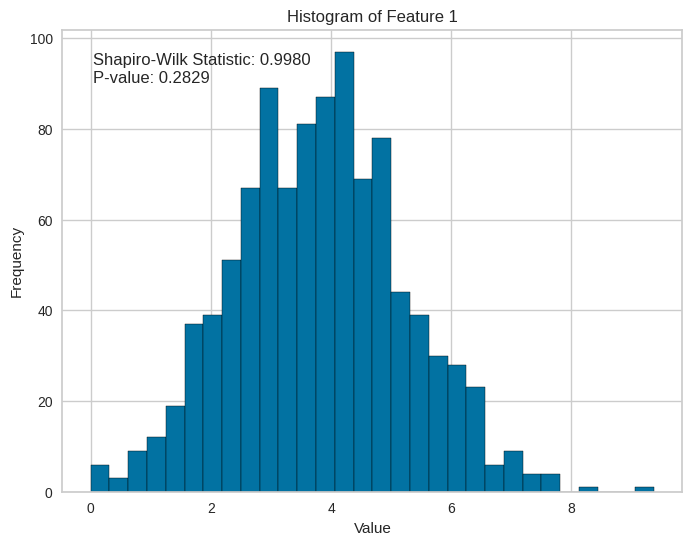

Feature 1: The feature likely follows a normal distribution.
--------------------


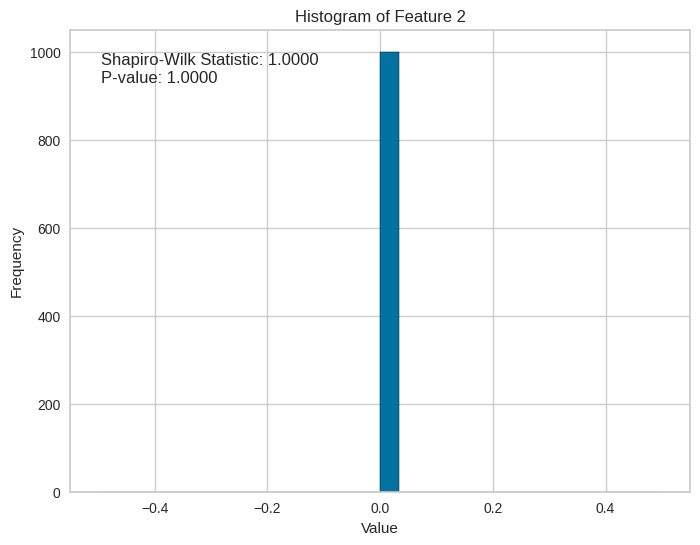

Feature 2: The feature likely follows a normal distribution.
--------------------


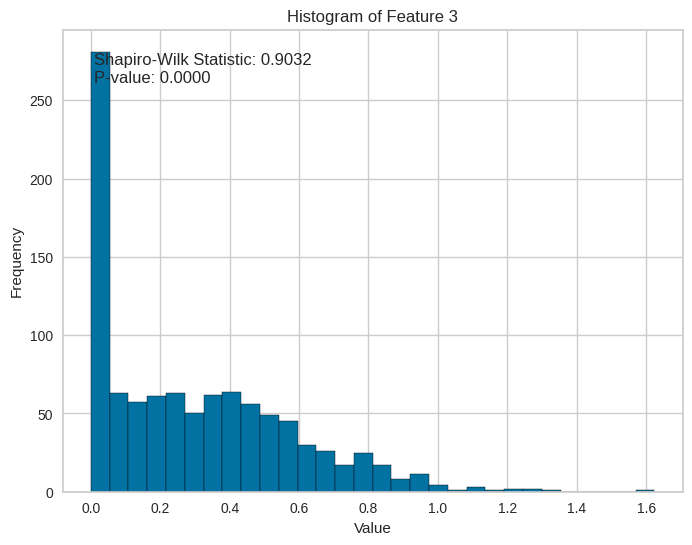

Feature 3: The feature likely does not follow a normal distribution.
--------------------


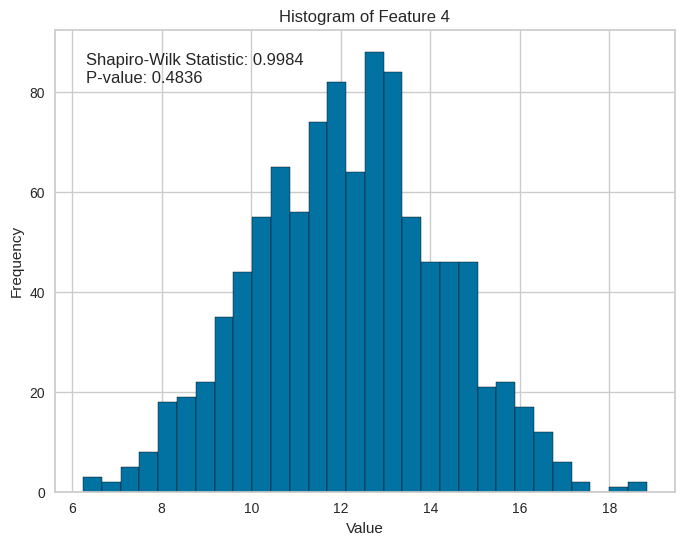

Feature 4: The feature likely follows a normal distribution.
--------------------


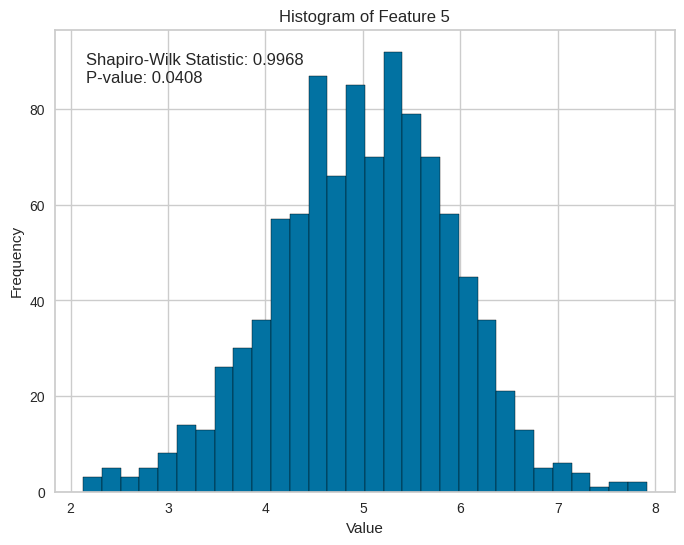

Feature 5: The feature likely does not follow a normal distribution.
--------------------


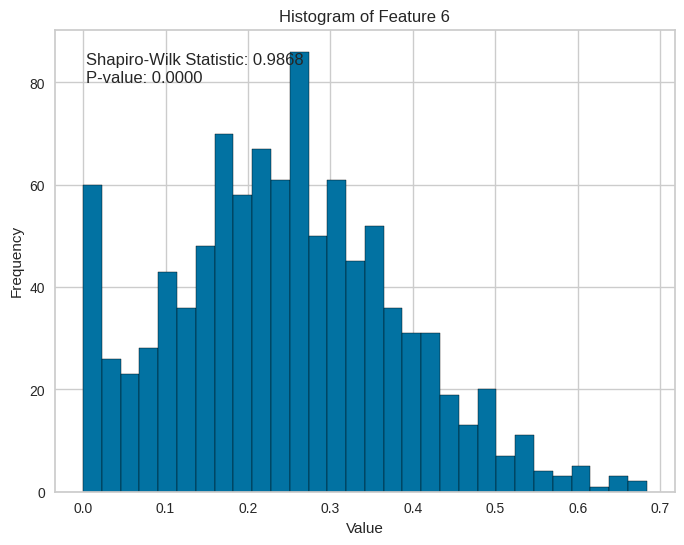

Feature 6: The feature likely does not follow a normal distribution.
--------------------


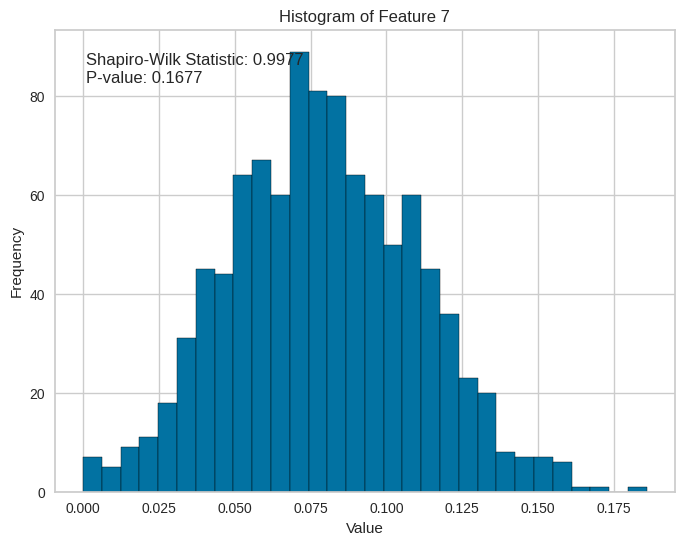

Feature 7: The feature likely follows a normal distribution.
--------------------


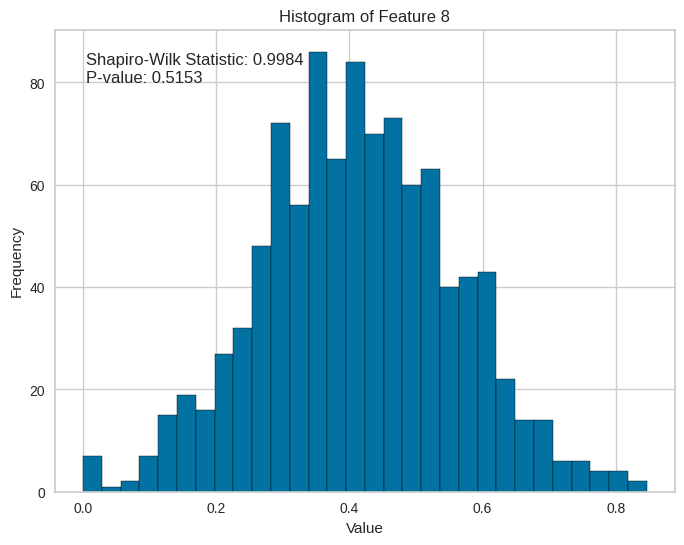

Feature 8: The feature likely follows a normal distribution.
--------------------


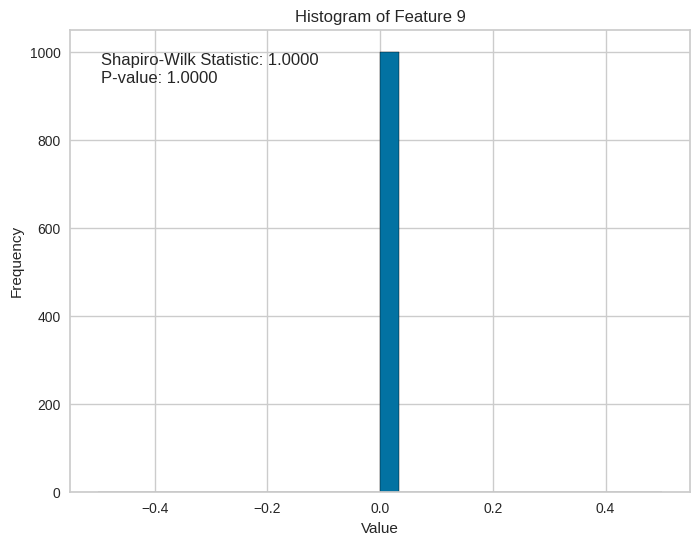

Feature 9: The feature likely follows a normal distribution.
--------------------


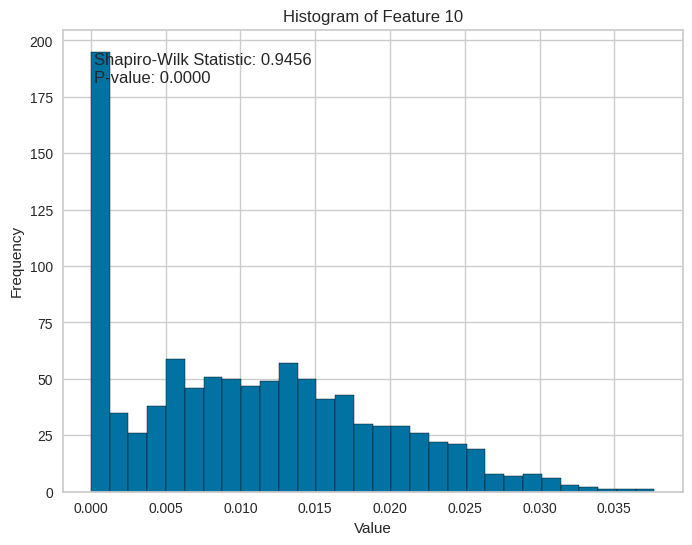

Feature 10: The feature likely does not follow a normal distribution.
--------------------


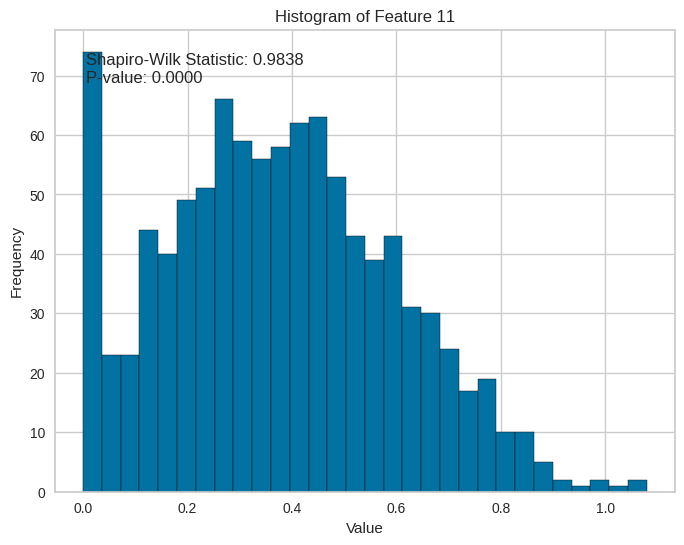

Feature 11: The feature likely does not follow a normal distribution.
--------------------


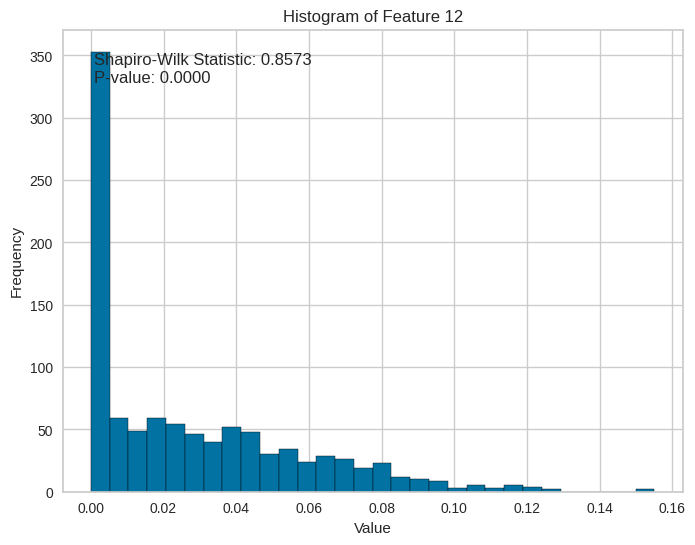

Feature 12: The feature likely does not follow a normal distribution.
--------------------


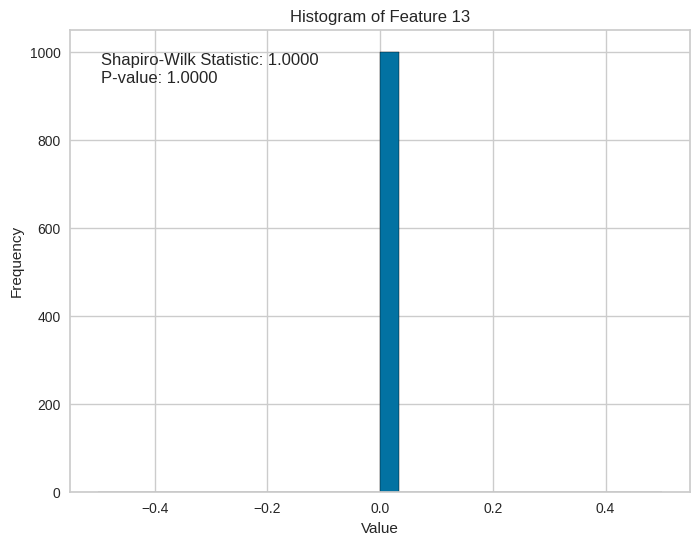

Feature 13: The feature likely follows a normal distribution.
--------------------


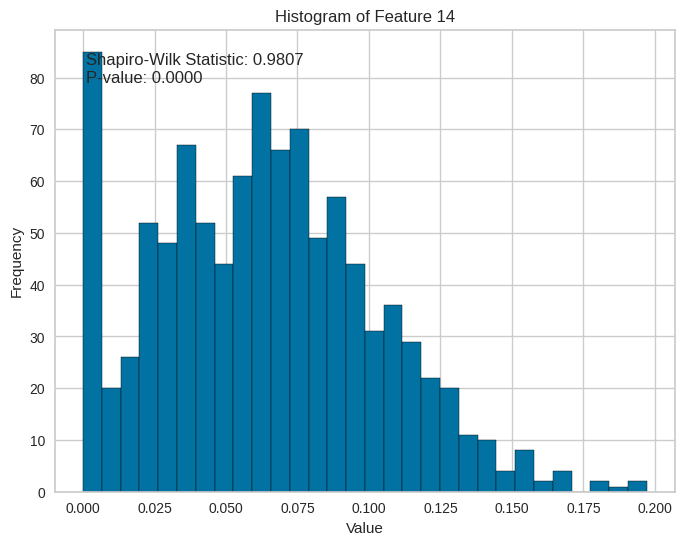

Feature 14: The feature likely does not follow a normal distribution.
--------------------


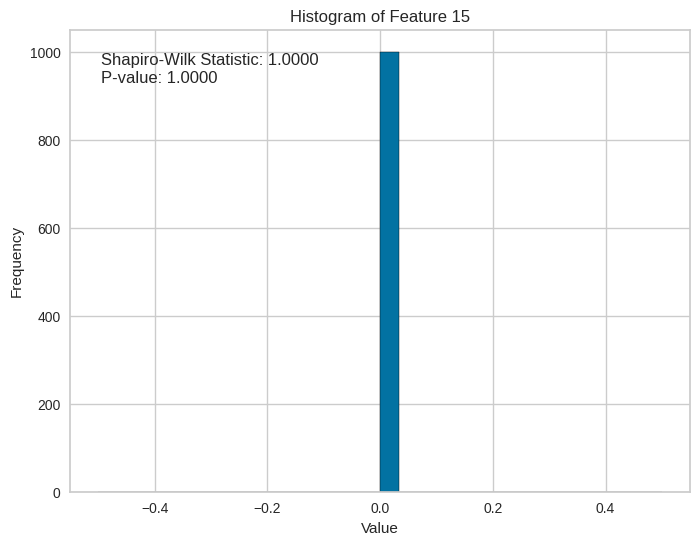

Feature 15: The feature likely follows a normal distribution.
--------------------


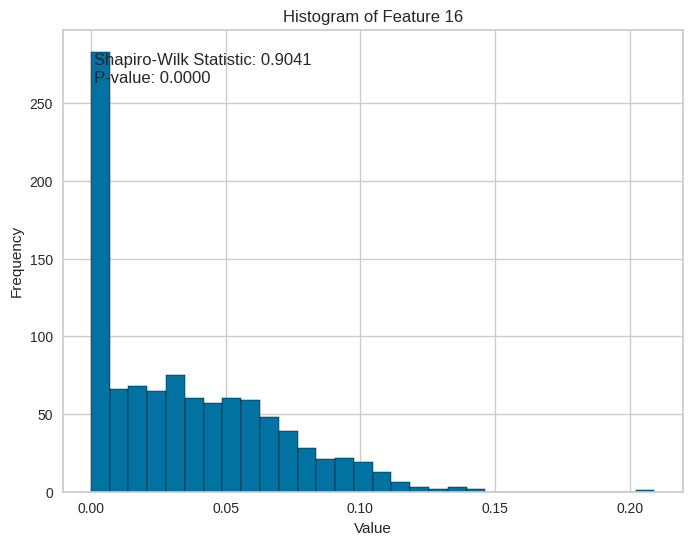

Feature 16: The feature likely does not follow a normal distribution.
--------------------


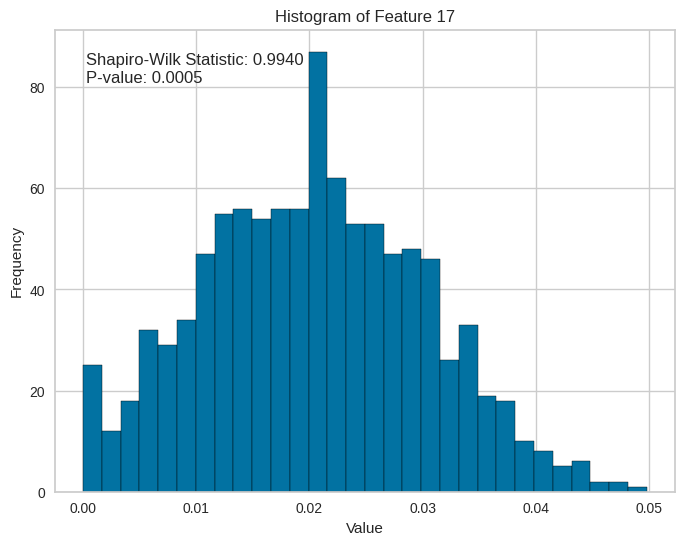

Feature 17: The feature likely does not follow a normal distribution.
--------------------


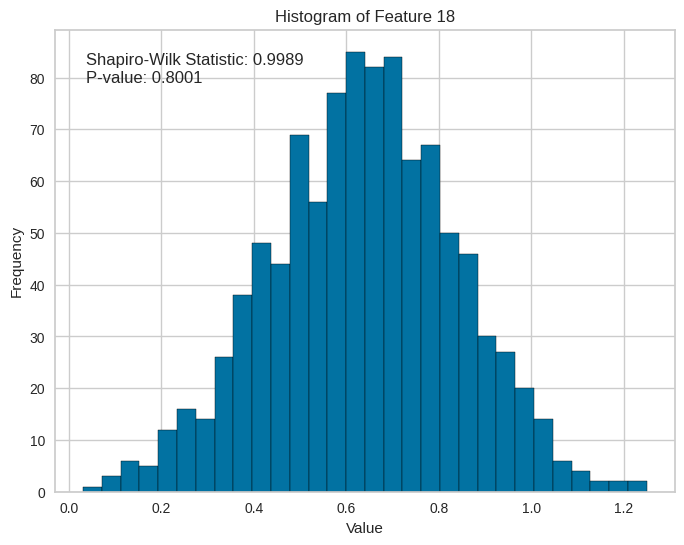

Feature 18: The feature likely follows a normal distribution.
--------------------


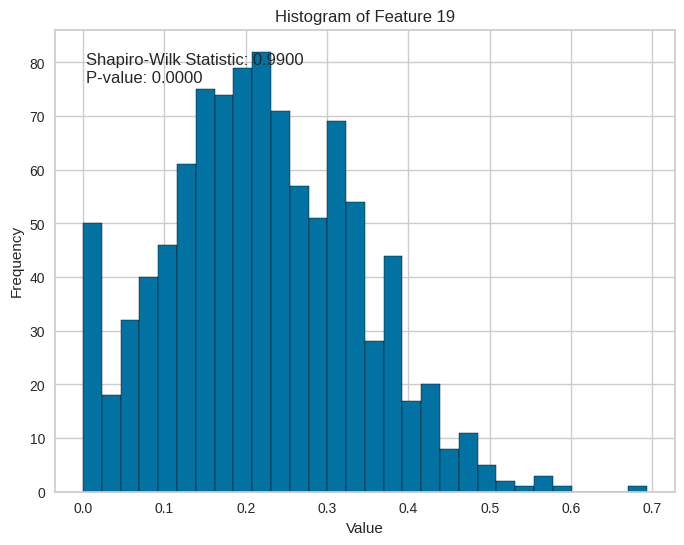

Feature 19: The feature likely does not follow a normal distribution.
--------------------


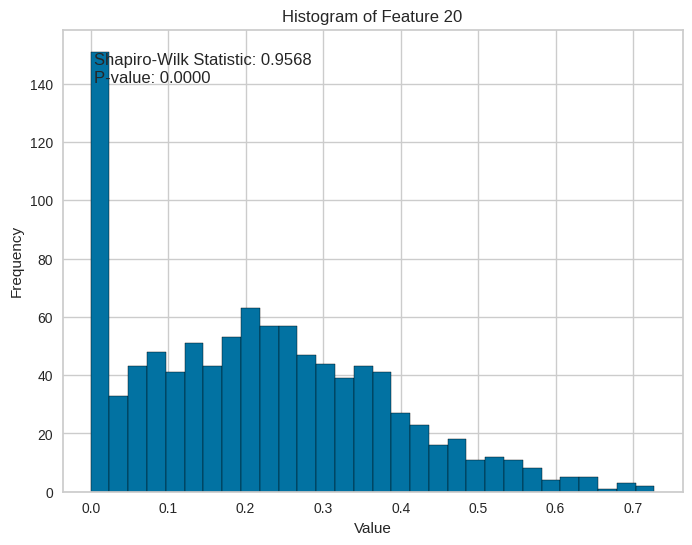

Feature 20: The feature likely does not follow a normal distribution.
--------------------


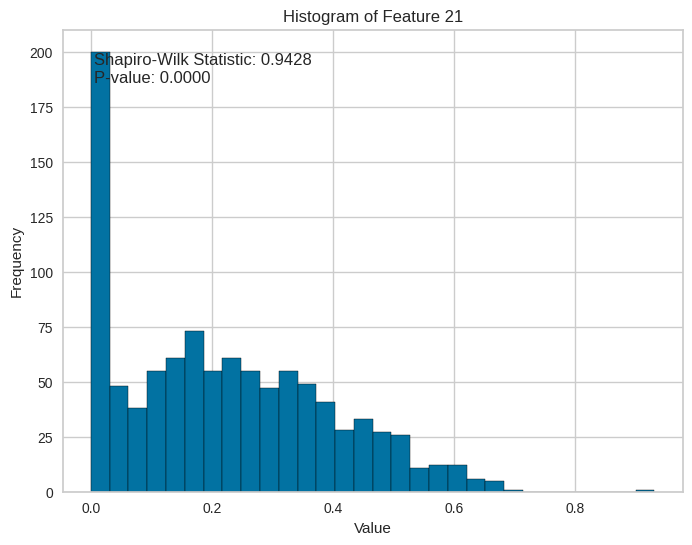

Feature 21: The feature likely does not follow a normal distribution.
--------------------


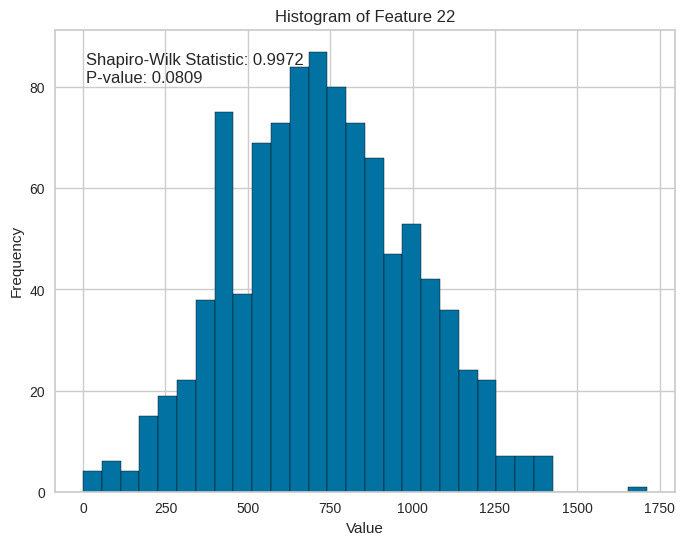

Feature 22: The feature likely follows a normal distribution.
--------------------


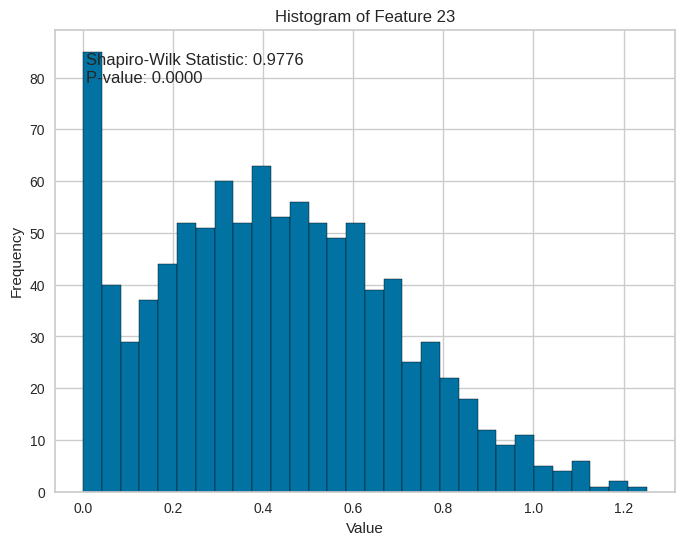

Feature 23: The feature likely does not follow a normal distribution.
--------------------


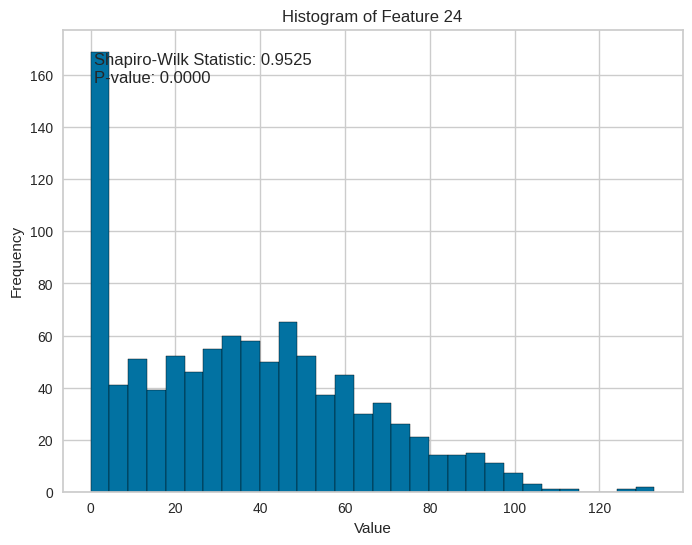

Feature 24: The feature likely does not follow a normal distribution.
--------------------


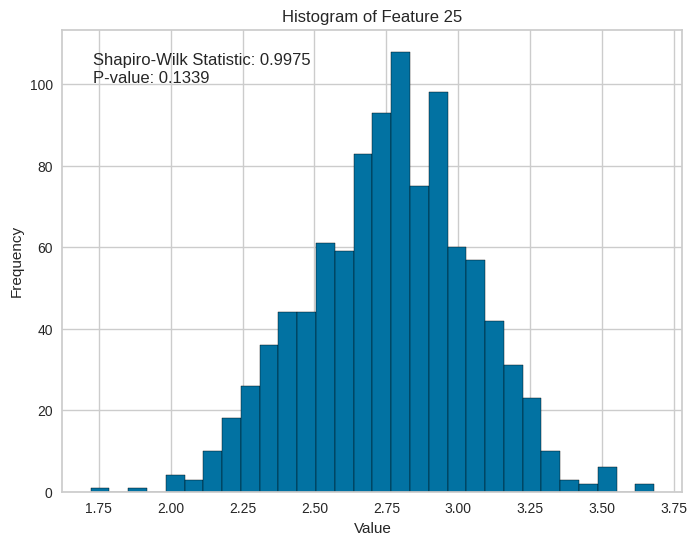

Feature 25: The feature likely follows a normal distribution.
--------------------


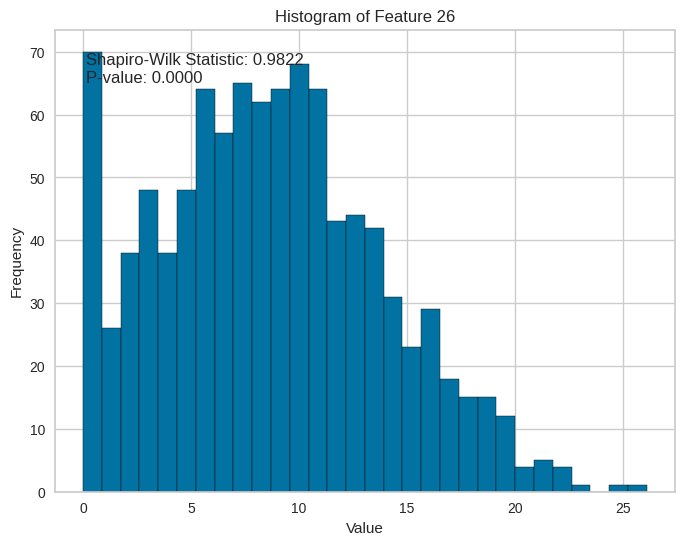

Feature 26: The feature likely does not follow a normal distribution.
--------------------


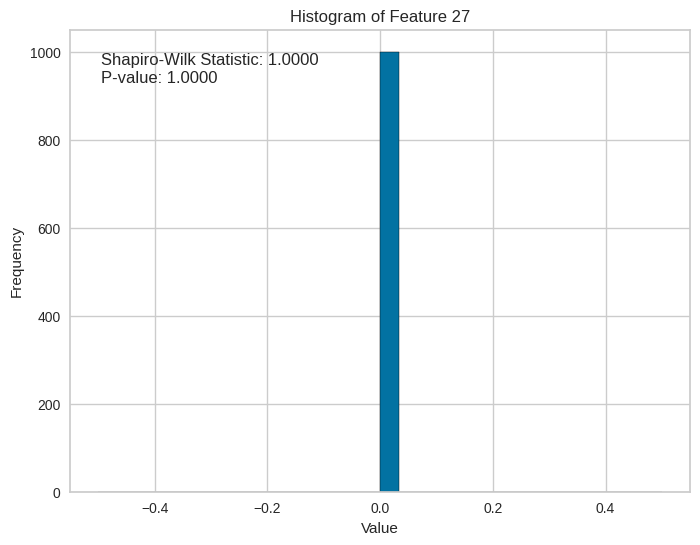

Feature 27: The feature likely follows a normal distribution.
--------------------


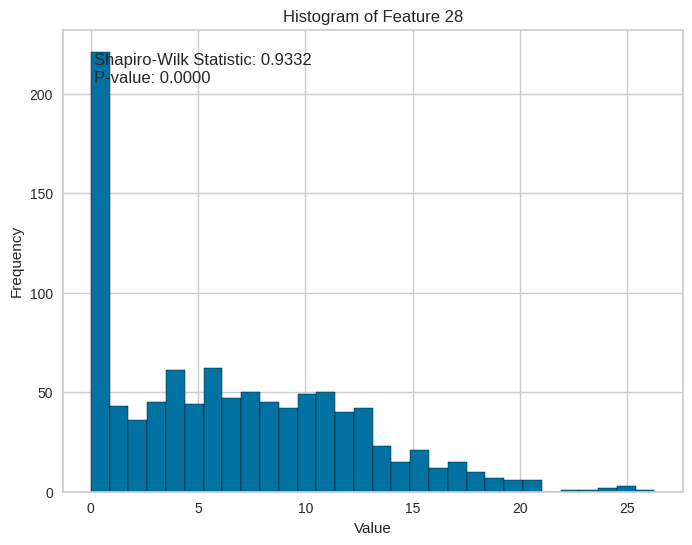

Feature 28: The feature likely does not follow a normal distribution.
--------------------


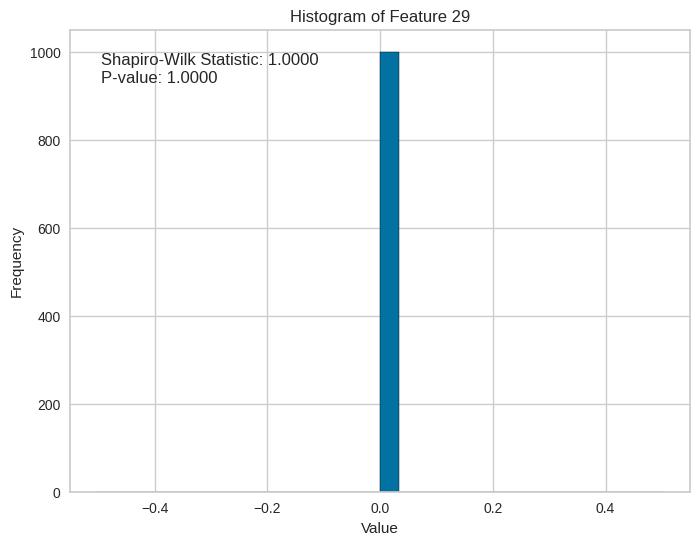

Feature 29: The feature likely follows a normal distribution.
--------------------


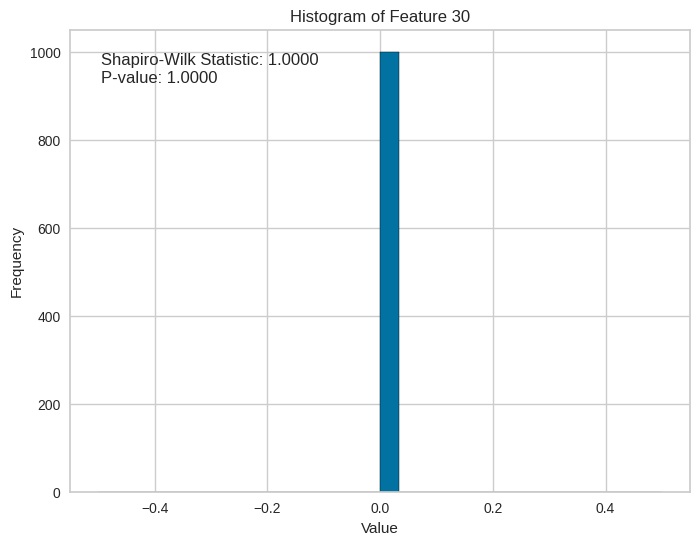

Feature 30: The feature likely follows a normal distribution.
--------------------


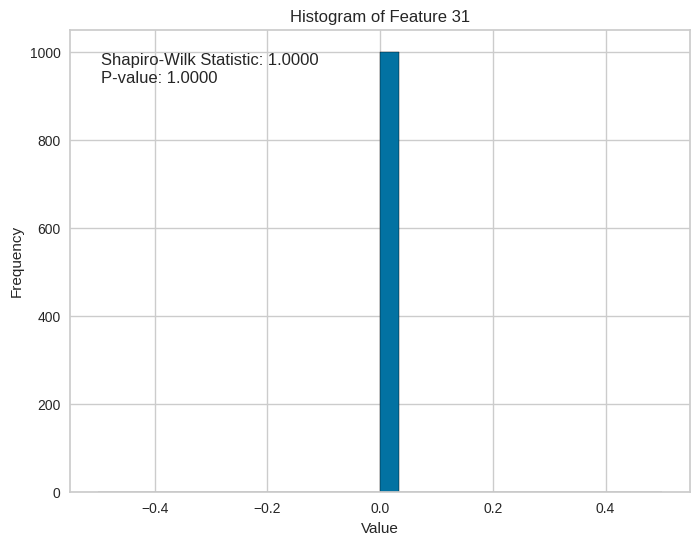

Feature 31: The feature likely follows a normal distribution.
--------------------


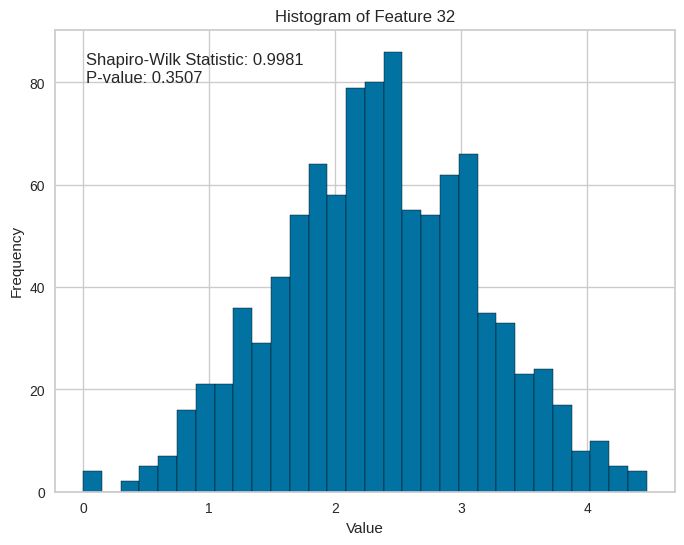

Feature 32: The feature likely follows a normal distribution.
--------------------


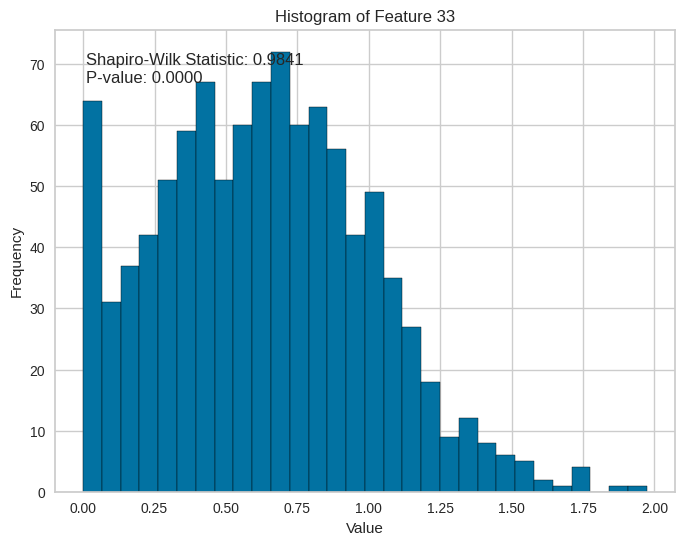

Feature 33: The feature likely does not follow a normal distribution.
--------------------


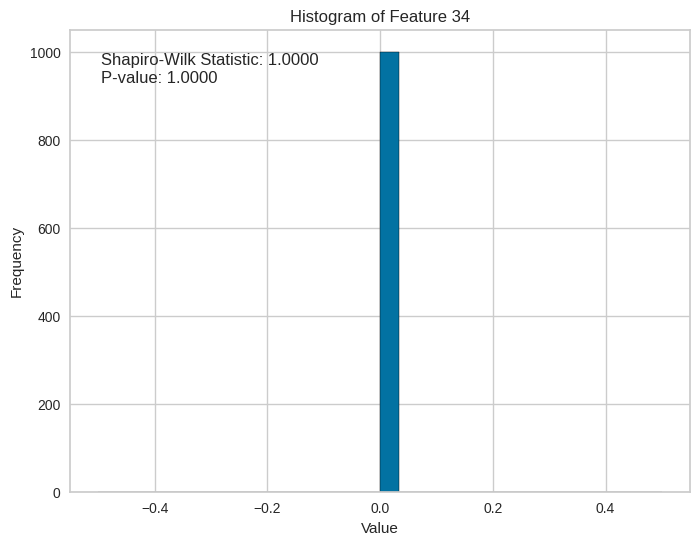

Feature 34: The feature likely follows a normal distribution.
--------------------


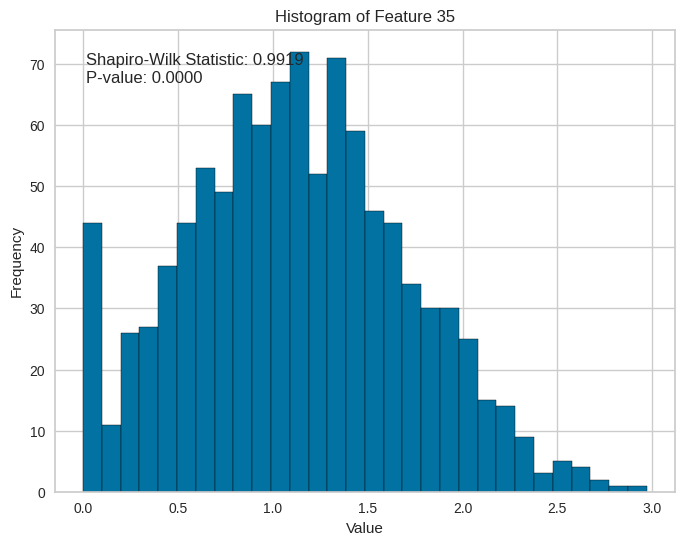

Feature 35: The feature likely does not follow a normal distribution.
--------------------


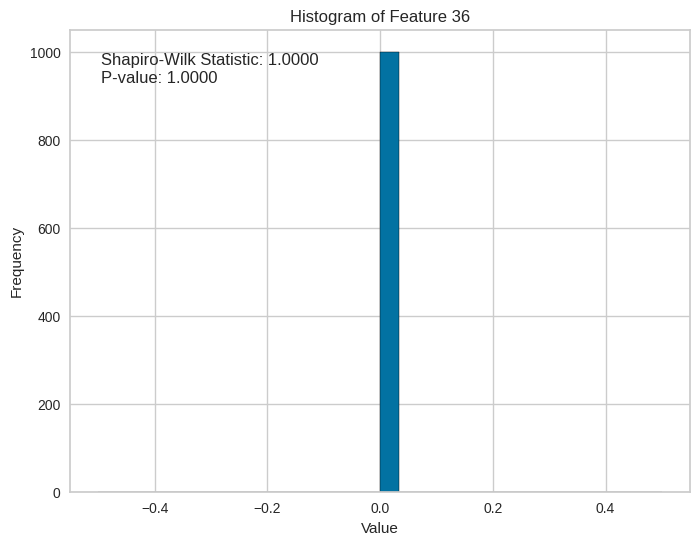

Feature 36: The feature likely follows a normal distribution.
--------------------


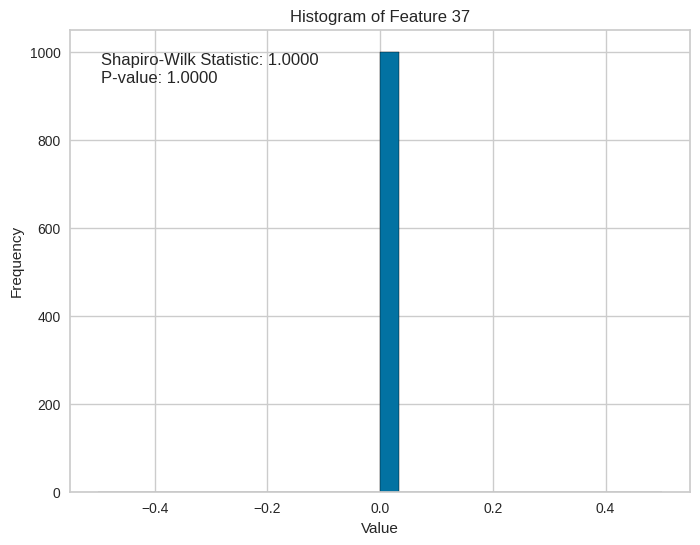

Feature 37: The feature likely follows a normal distribution.
--------------------


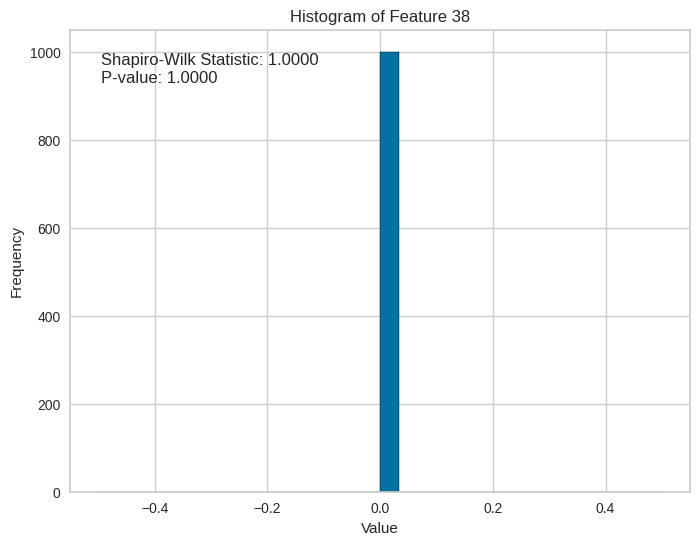

Feature 38: The feature likely follows a normal distribution.
--------------------


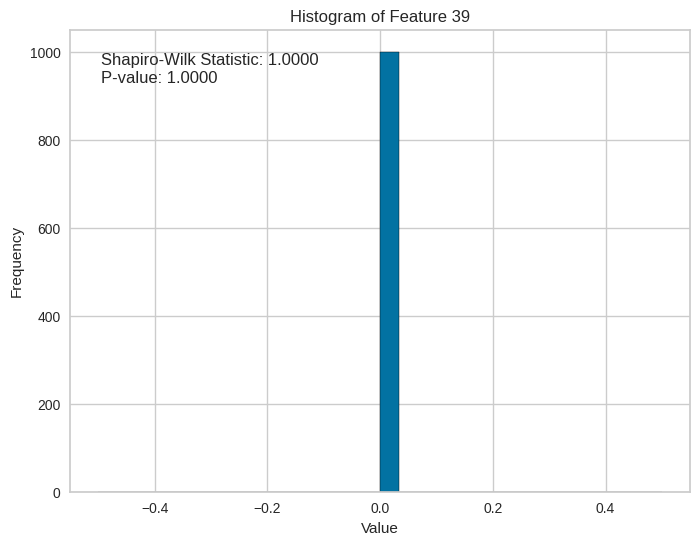

Feature 39: The feature likely follows a normal distribution.
--------------------


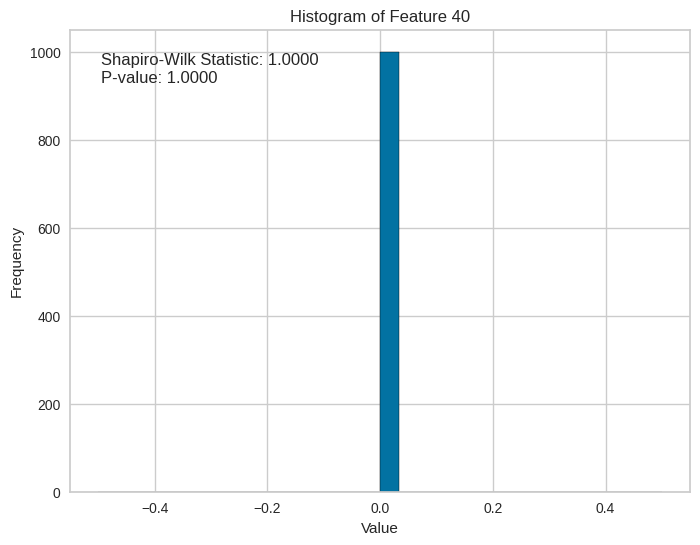

Feature 40: The feature likely follows a normal distribution.
--------------------


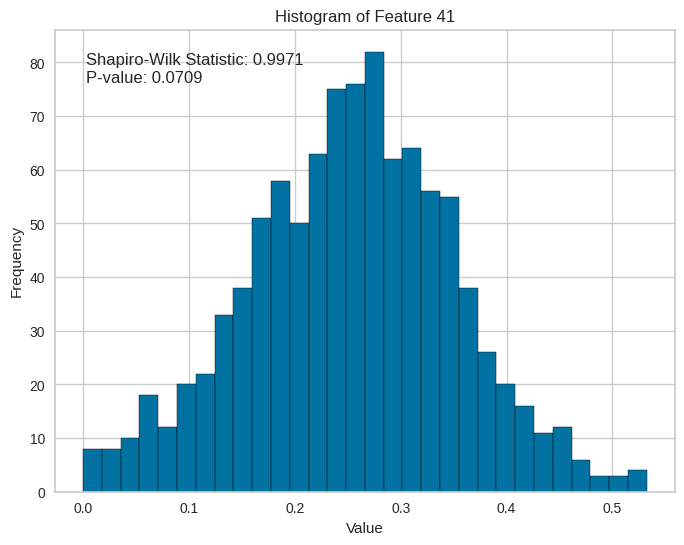

Feature 41: The feature likely follows a normal distribution.
--------------------


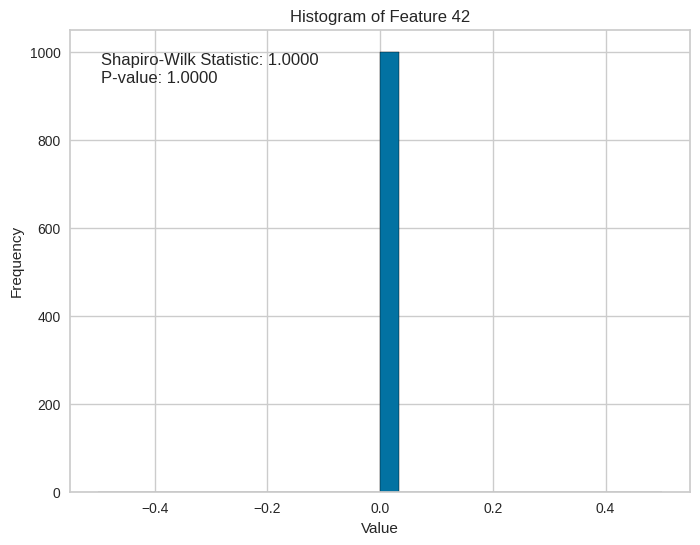

Feature 42: The feature likely follows a normal distribution.
--------------------


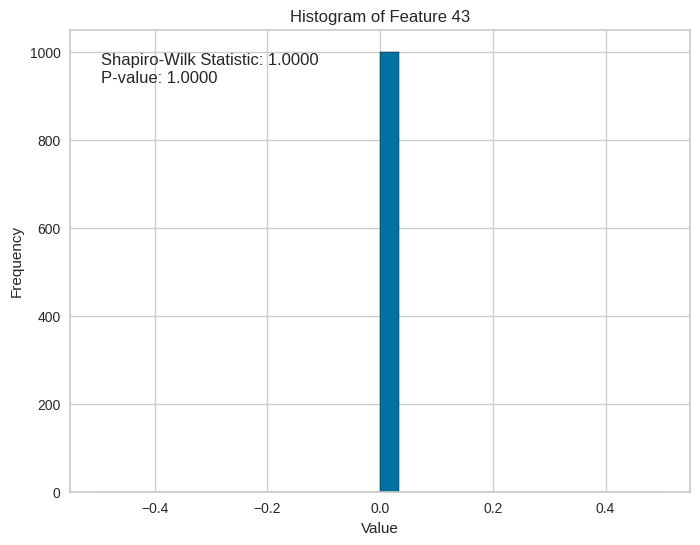

Feature 43: The feature likely follows a normal distribution.
--------------------


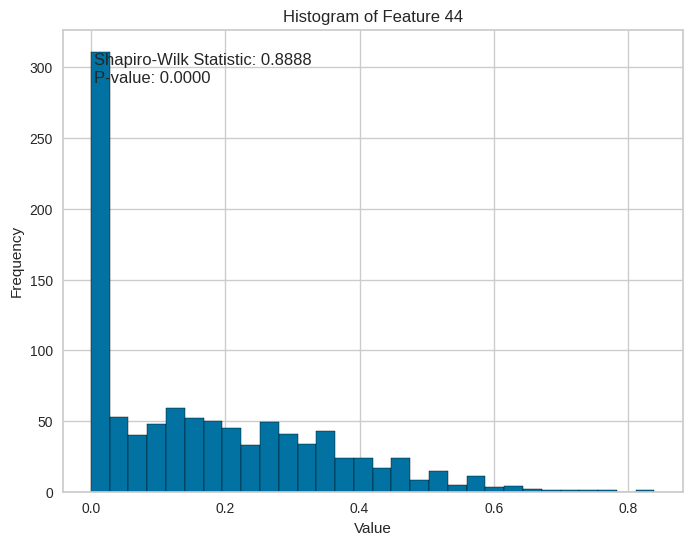

Feature 44: The feature likely does not follow a normal distribution.
--------------------


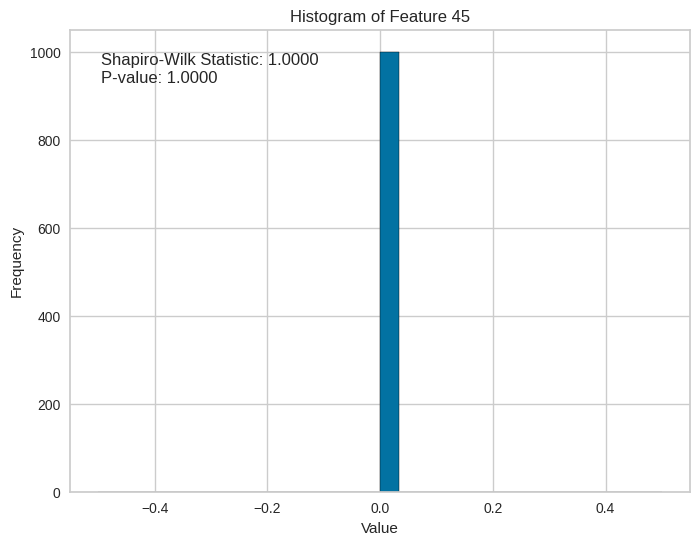

Feature 45: The feature likely follows a normal distribution.
--------------------


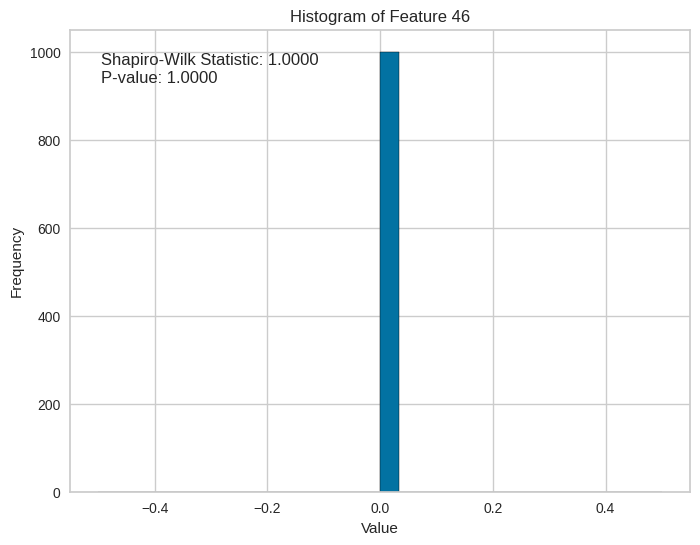

Feature 46: The feature likely follows a normal distribution.
--------------------


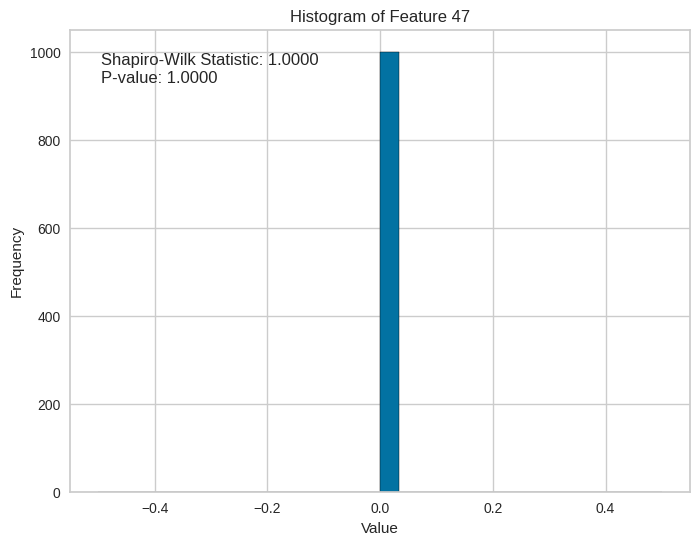

Feature 47: The feature likely follows a normal distribution.
--------------------


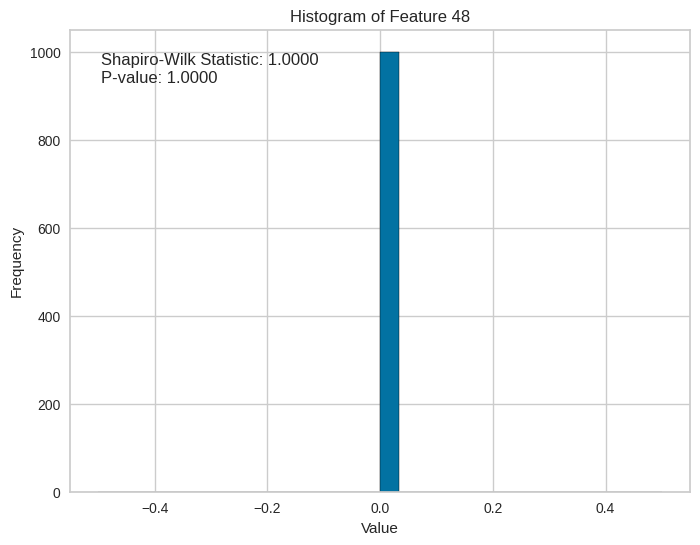

Feature 48: The feature likely follows a normal distribution.
--------------------


In [23]:
import matplotlib.pyplot as plt

for i in range(synthetic_data_df.shape[1]):
  feature = synthetic_data_df.iloc[:, i]
  statistic, p_value = shapiro(feature)

  plt.figure(figsize=(8, 6))
  plt.hist(feature, bins=30, edgecolor='black')
  plt.title(f"Histogram of Feature {i+1}")
  plt.xlabel("Value")
  plt.ylabel("Frequency")

  # Adicionando Shapiro-Wilk Statistic e P-value ao plot
  plt.text(0.05, 0.95, f"Shapiro-Wilk Statistic: {statistic:.4f}\nP-value: {p_value:.4f}",
           transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

  plt.show()

  if p_value > 0.05:
    print(f"Feature {i+1}: The feature likely follows a normal distribution.")
  else:
    print(f"Feature {i+1}: The feature likely does not follow a normal distribution.")
  print("-" * 20)


# Parte 1b: Regressão Linear e Random Forest

Joguei os valores simulados no modelo RenovaCalc e exportei a Intensidade de Carbono calculada --> target variable.

Teste de Random Forest

In [30]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Importando e lendo o CSV resultante do RenovaCalc
df = pd.read_csv('DataBase - synthetic_data.csv')

# Definindo a variável resposta
# Neste caso utilizaresmos 'IC' como  variavel resposta e o resto como preditores
target_column = 'IC'  # Variável resposta
X = df.drop(target_column, axis=1)  # Features (valores independentes)
y = df[target_column]  # Target (variável dependente)

# Dividindo os dados em treinamento e teste (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinando diversos modelos de regressão

# Modelo de Regressão Linear
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin = lin_reg.predict(X_test)

# Modelo de Random Forest
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_train)
y_pred_rf = rf_reg.predict(X_test)

# Avaliando os modelos

# Métricas da Reg. Linear
mse_lin = mean_squared_error(y_test, y_pred_lin)
mae_lin = mean_absolute_error(y_test, y_pred_lin)
r2_lin = r2_score(y_test, y_pred_lin)

# Métricas de Random Forest
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Print
print("Linear Regression Evaluation:")
print(f"  MSE: {mse_lin:.4f}")
print(f"  MAE: {mae_lin:.4f}")
print(f"  R²: {r2_lin:.4f}")
print("-" * 30)

print("Random Forest Regressor Evaluation:")
print(f"  MSE: {mse_rf:.4f}")
print(f"  MAE: {mae_rf:.4f}")
print(f"  R²: {r2_rf:.4f}")
print("-" * 30)

# Salvar CSV
predictions_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted (Linear)': y_pred_lin,
    'Predicted (Random Forest)': y_pred_rf
})
predictions_df.to_csv('model_predictions.csv', index=False)
print("Predictions saved to 'model_predictions.csv'.")


Linear Regression Evaluation:
  MSE: 0.8378
  MAE: 0.3115
  R²: 0.9481
------------------------------
Random Forest Regressor Evaluation:
  MSE: 3.0777
  MAE: 1.3008
  R²: 0.8092
------------------------------
Predictions saved to 'model_predictions.csv'.


## Barchart métricas (RF x RL)

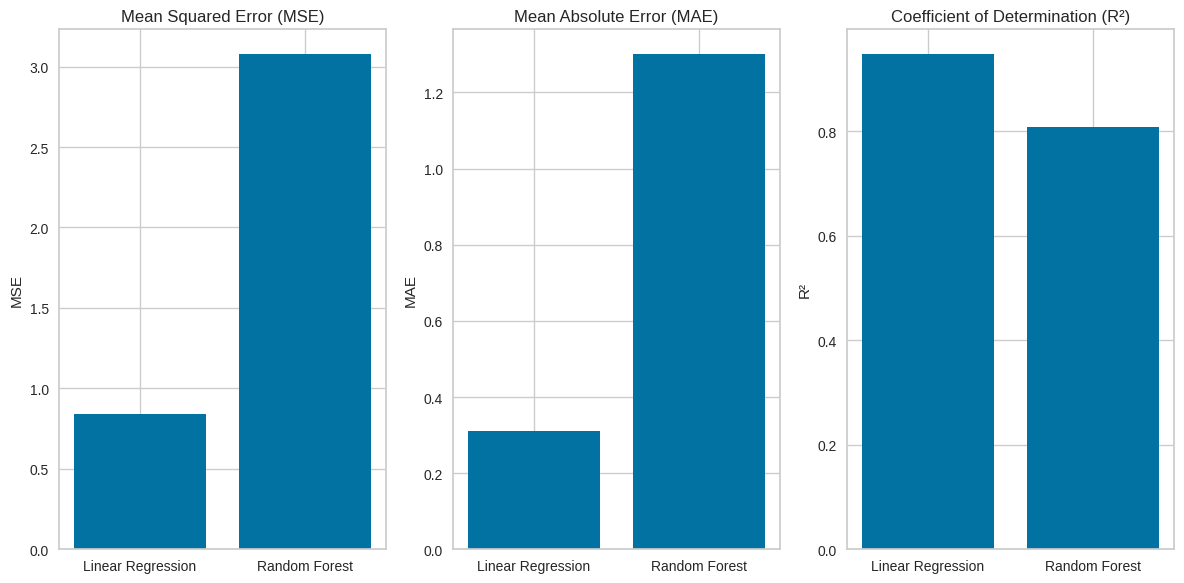

In [31]:
import matplotlib.pyplot as plt

# Criando um barchart para comparar as métricas do random forest e reg.linear
models = ['Linear Regression', 'Random Forest']
mse_values = [mse_lin, mse_rf]
mae_values = [mae_lin, mae_rf]
r2_values = [r2_lin, r2_rf]

x = range(len(models))

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.bar(x, mse_values)
plt.xticks(x, models)
plt.ylabel('MSE')
plt.title('Mean Squared Error (MSE)')

plt.subplot(1, 3, 2)
plt.bar(x, mae_values)
plt.xticks(x, models)
plt.ylabel('MAE')
plt.title('Mean Absolute Error (MAE)')

plt.subplot(1, 3, 3)
plt.bar(x, r2_values)
plt.xticks(x, models)
plt.ylabel('R²')
plt.title('Coefficient of Determination (R²)')

plt.tight_layout()
plt.show()


## Teste MSRE

In [32]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming you have y_test and y_pred_rf (from your Random Forest model)

# Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred_rf)

# Calculate the Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")


Mean Squared Error (MSE): 3.0777
Root Mean Squared Error (RMSE): 1.7543


# Parte 1c: Feature importance tests

Quais variáveis são de maior importância?
3 métodos: Lasso, XGB Regressor e LinearRegression

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

# Train Lasso model
lasso = Lasso(alpha=0.01)  # Alpha controls the strength of the regularization
lasso.fit(X_train, y_train)

# Get feature importance (coefficients)
importance = lasso.coef_

# Display the feature importances
for feature, coef in zip(X.columns, importance):
    print(f"Feature: {feature}, Coefficient: {coef:.4f}")



In [ ]:
import xgboost as xgb

# Train XGBoost model
model = xgb.XGBRegressor()
model.fit(X_train, y_train)

# Get feature importances
importances = model.feature_importances_

# Display feature importances
for feature, importance in zip(X.columns, importances):
    print(f"Feature: {feature}, Importance: {importance:.4f}")


In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# Initialize RFE with a base estimator
model = LinearRegression()
selector = RFE(model, n_features_to_select=5)
selector = selector.fit(X_train, y_train)

# Get ranking of features
ranking = selector.ranking_

# Display feature rankings
for feature, rank in zip(X.columns, ranking):
    print(f"Feature: {feature}, Rank: {rank}")


In [ ]:
# prompt: create a polynomial regression test

from sklearn.preprocessing import PolynomialFeatures

# Step 1: Create polynomial features
poly = PolynomialFeatures(degree=2)  # You can adjust the degree as needed
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Step 2: Train a linear regression model on the polynomial features
poly_reg = LinearRegression()
poly_reg.fit(X_train_poly, y_train)

# Step 3: Make predictions on the test set
y_pred_poly = poly_reg.predict(X_test_poly)

# Step 4: Evaluate the model
mse_poly = mean_squared_error(y_test, y_pred_poly)
mae_poly = mean_absolute_error(y_test, y_pred_poly)
r2_poly = r2_score(y_test, y_pred_poly)

# Print the evaluation metrics for the polynomial regression model
print("Polynomial Regression Evaluation:")
print(f"  MSE: {mse_poly:.4f}")
print(f"  MAE: {mae_poly:.4f}")
print(f"  R²: {r2_poly:.4f}")
print("-" * 30)


In [ ]:
# prompt: create a Principal Component Analysis (PCA)

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming X is your feature matrix (DataFrame)
# Standardize the features (important for PCA)
x = StandardScaler().fit_transform(X)

# Create a PCA object with the desired number of components
pca = PCA(n_components=2)  # You can choose the number of components you want

# Fit the PCA model to your data
principalComponents = pca.fit_transform(x)

# Create a new DataFrame with the principal components
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

# You can also get the explained variance ratio for each component
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance_ratio)

# You can then use the principal components for further analysis or visualization
# For example, you can plot the first two principal components:
plt.figure(figsize=(8, 6))
plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of your data')
plt.show()


## Interpretação prévia

Os testes de feature importance mostraram que, o Nitrato de Amônio, Uréia e Diesel são os fatores que mais influenciam no resultado final de IC.

A partir dessa informação eu possso atribuir pesos para cada feature para assim criar o fator de uso de insumos.


**IMPORTANTE**: Os dados ainda não estão completos, em especial, precisa ser definido área queimada como importante fator.

# Parte 2: Auto ML

## Criando grupo teste


In [33]:
X = df
y = df

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train


,Percentual da área queimada,Área Queimada,Calcário calcítico,Calcário dolomítico,Gesso,Ureia,Fosfato Monoamônico (MAP),Fosfato Monoamônico (MAP).1,Fosfato diamônico (DAP),Fosfato diamônico (DAP).1,...,Gasolina C,Etanol hidratado,Biometano de terceiros,Biometano próprio,Eletricidade da rede - mix médio,Eletricidade - PCH,Eletricidade - biomassa,Eletricidade - eólica,Eletricidade - solar,IC
29,2.605432,0,0.000000,13.136340,3.541990,0.109913,0.065709,0.373901,0,0.006201,...,0,0.204731,0,0,0.284662,0,0,0,0,20.47
535,7.079131,0,0.429666,13.718538,5.310192,0.158686,0.080739,0.286651,0,0.000000,...,0,0.360385,0,0,0.000000,0,0,0,0,27.89
695,4.858324,0,0.397091,11.205916,4.988362,0.059487,0.063100,0.387826,0,0.002741,...,0,0.188091,0,0,0.256576,0,0,0,0,14.17
557,4.131069,0,0.310811,8.955000,5.043623,0.373467,0.117962,0.386840,0,0.013965,...,0,0.167958,0,0,0.000000,0,0,0,0,27.32
836,5.406297,0,0.000000,14.489881,5.593696,0.254805,0.131775,0.341085,0,0.009226,...,0,0.102595,0,0,0.109696,0,0,0,0,23.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,5.461082,0,0.646423,11.984732,3.919842,0.153740,0.076794,0.363318,0,0.006154,...,0,0.120051,0,0,0.351796,0,0,0,0,28.09
270,4.413307,0,0.000000,8.809010,4.399105,0.354313,0.119547,0.517461,0,0.021938,...,0,0.405017,0,0,0.064016,0,0,0,0,25.63
860,3.905489,0,0.235143,12.478807,4.576808,0.326273,0.140692,0.567318,0,0.010529,...,0,0.204109,0,0,0.321607,0,0,0,0,27.02
435,2.882363,0,0.035274,13.010535,6.052558,0.217822,0.073702,0.438887,0,0.022193,...,0,0.425772,0,0,0.249434,0,0,0,0,31.05


## Auto ML

In [35]:
reg = setup(data = X_train, target = 'IC', session_id=42)

,Description,Value
0,Session id,42
1,Target,IC
2,Target type,Regression
3,Original data shape,"(800, 49)"
4,Transformed data shape,"(800, 49)"
5,Transformed train set shape,"(560, 49)"
6,Transformed test set shape,"(240, 49)"
7,Numeric features,48
8,Preprocess,True
9,Imputation type,simple


In [36]:
best = compare_models(cross_validation=False)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,0.3966,2.1462,1.4650,0.8949,0.0422,0.0134,0.0300
lr,Linear Regression,0.3956,2.1560,1.4683,0.8945,0.0423,0.0133,0.0300
lar,Least Angle Regression,0.4029,2.1641,1.4711,0.8941,0.0424,0.0136,0.0200
ridge,Ridge Regression,0.4348,2.1770,1.4755,0.8934,0.0426,0.0149,0.0200
gbr,Gradient Boosting Regressor,1.0600,3.5216,1.8766,0.8276,0.0610,0.0397,0.7300
lightgbm,Light Gradient Boosting Machine,1.0593,3.5647,1.8880,0.8255,0.0623,0.0400,0.1500
et,Extra Trees Regressor,1.3975,4.7563,2.1809,0.7672,0.0746,0.0537,0.4500
xgboost,Extreme Gradient Boosting,1.4628,4.8720,2.2073,0.7615,0.0757,0.0560,0.8900
rf,Random Forest Regressor,1.5423,5.4045,2.3247,0.7355,0.0798,0.0592,0.9500
huber,Huber Regressor,1.7246,5.9637,2.4421,0.7081,0.0827,0.0648,0.2300


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

In [37]:
best

BayesianRidge()

In [38]:
best.get_params()

{'alpha_1': 1e-06,
 'alpha_2': 1e-06,
 'alpha_init': None,
 'compute_score': False,
 'copy_X': True,
 'fit_intercept': True,
 'lambda_1': 1e-06,
 'lambda_2': 1e-06,
 'lambda_init': None,
 'max_iter': None,
 'n_iter': 'deprecated',
 'tol': 0.001,
 'verbose': False}

### Análise dos resultados (treino x teste)

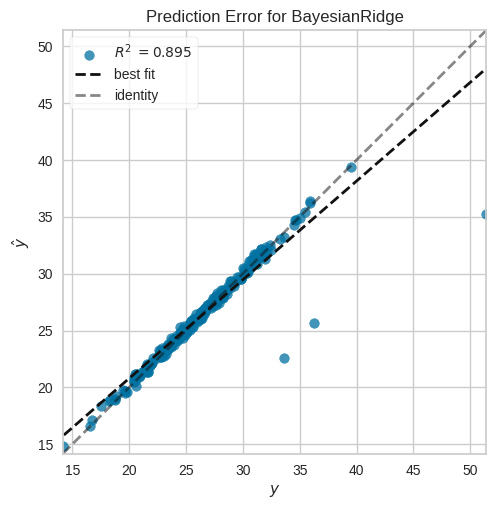

In [39]:
plot_model(best, plot = 'error')

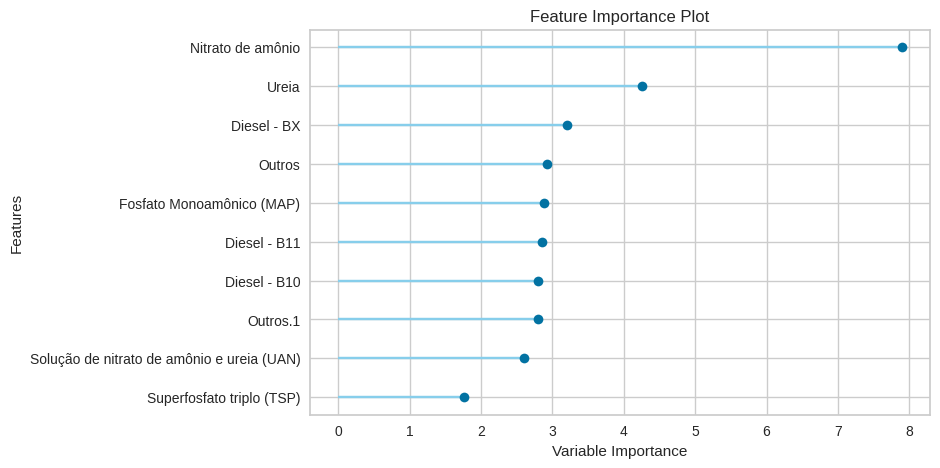

In [40]:
plot_model(best, plot = 'feature')

In [41]:
tuned_model = tune_model(best)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.2739,0.1154,0.3397,0.9908,0.0130,0.0107
1,0.3082,0.1391,0.3729,0.9910,0.0145,0.0122
2,0.2646,0.1068,0.3267,0.9945,0.0128,0.0107
3,0.7906,7.0228,2.6500,0.6373,0.0905,0.0247
4,0.2637,0.1175,0.3427,0.9933,0.0135,0.0107
5,0.3245,0.1503,0.3877,0.9896,0.0143,0.0124
6,0.2744,0.1188,0.3447,0.9916,0.0134,0.0108
7,0.6907,7.8303,2.7983,0.6295,0.0782,0.0186
8,0.4460,1.5308,1.2372,0.9137,0.0500,0.0168


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [42]:
tuned_model.get_params()

{'alpha_1': 1e-06,
 'alpha_2': 1e-06,
 'alpha_init': None,
 'compute_score': False,
 'copy_X': True,
 'fit_intercept': True,
 'lambda_1': 1e-06,
 'lambda_2': 1e-06,
 'lambda_init': None,
 'max_iter': None,
 'n_iter': 'deprecated',
 'tol': 0.001,
 'verbose': False}

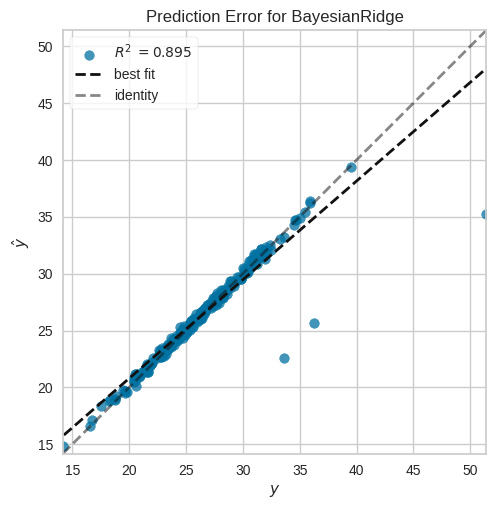

In [43]:
plot_model(tuned_model, plot = 'error')

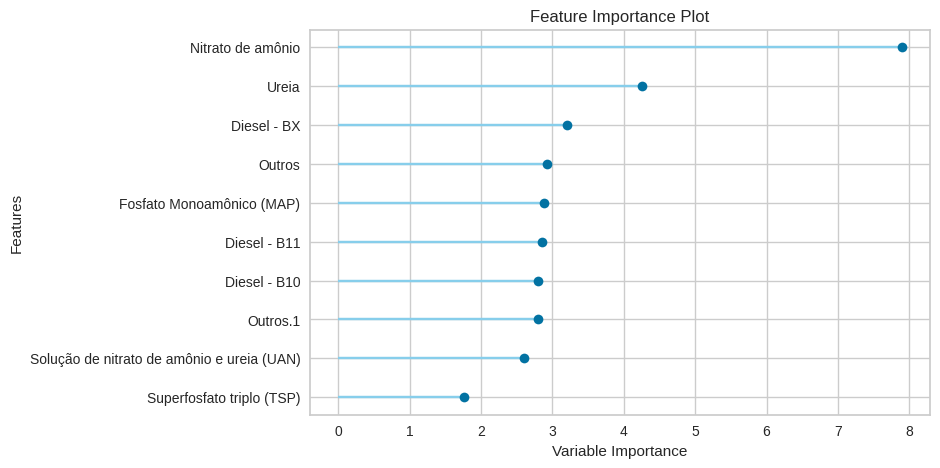

In [44]:
plot_model(tuned_model, plot = 'feature')

In [45]:
prediction = predict_model(tuned_model, data = X_test)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,0.3312,0.8259,0.9088,0.9488,0.0287,0.0124


In [46]:
prediction

,Percentual da área queimada,Área Queimada,Calcário calcítico,Calcário dolomítico,Gesso,Ureia,Fosfato Monoamônico (MAP),Fosfato Monoamônico (MAP).1,Fosfato diamônico (DAP),Fosfato diamônico (DAP).1,...,Etanol hidratado,Biometano de terceiros,Biometano próprio,Eletricidade da rede - mix médio,Eletricidade - PCH,Eletricidade - biomassa,Eletricidade - eólica,Eletricidade - solar,IC,prediction_label
521,3.002109,0,1.290203,10.063158,5.186866,0.367492,0.018877,0.382913,0,0.002928,...,0.229609,0,0,0.050962,0,0,0,0,24.040001,24.146908
737,3.387084,0,0.638820,11.668022,5.151353,0.291635,0.112458,0.326205,0,0.019609,...,0.188065,0,0,0.000000,0,0,0,0,33.910000,34.179256
740,4.842528,0,0.030487,13.883847,1.265874,0.304166,0.072163,0.576706,0,0.000000,...,0.184325,0,0,0.153312,0,0,0,0,25.370001,24.809980
660,3.570893,0,0.105469,10.918592,4.611103,0.000000,0.077690,0.405477,0,0.000000,...,0.109896,0,0,0.328998,0,0,0,0,24.830000,24.736279
411,6.306730,0,0.662947,10.627831,3.451776,0.255772,0.126478,0.421490,0,0.021121,...,0.064688,0,0,0.000000,0,0,0,0,29.430000,29.699080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,5.109766,0,0.000000,11.974264,5.887786,0.276931,0.107331,0.188268,0,0.001097,...,0.074885,0,0,0.298638,0,0,0,0,28.160000,28.481819
332,2.827009,0,0.000000,14.644729,5.413180,0.378469,0.045498,0.341930,0,0.000000,...,0.138965,0,0,0.238305,0,0,0,0,27.660000,27.723276
208,5.545164,0,0.128501,8.369145,6.181635,0.509257,0.072994,0.481069,0,0.040315,...,0.245813,0,0,0.152195,0,0,0,0,28.660000,28.587938
613,2.567710,0,0.000000,10.549413,4.622572,0.286492,0.109726,0.465992,0,0.003743,...,0.116125,0,0,0.264950,0,0,0,0,28.540001,28.509344


In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

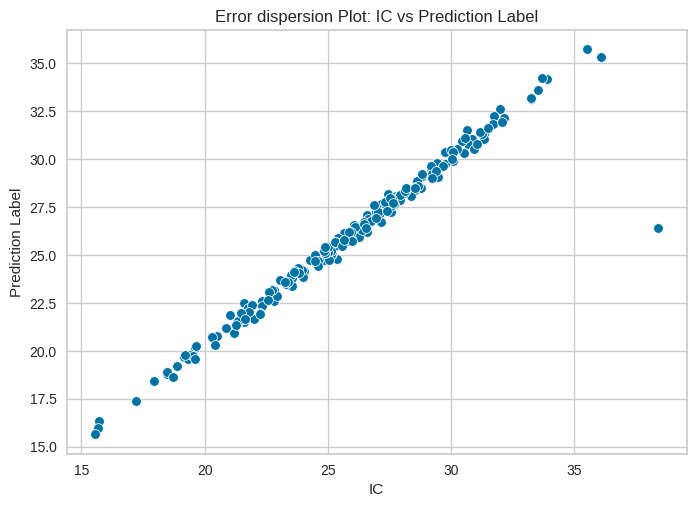

In [51]:
# Gráfico de dispersão de erros usando seaborn

sns.scatterplot(data=prediction, x='IC', y='prediction_label')

plt.xlabel('IC')
plt.ylabel('Prediction Label')
plt.title('Error dispersion Plot: IC vs Prediction Label')
plt.show()

# Parte 2: Explorando os dados de Perfil Típico

In [52]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans

In [54]:
df_pt = pd.read_csv('/content/drive/MyDrive/Rota1/Rota1.csv')
df_pt['UF'] = df_pt['UF'].astype(int)
df_pt

,UF,Percentual da área queimada,Calcário calcítico,Calcário dolomítico,Gesso,Ureia,Fosfato Monoamônico (MAP),Fosfato Monoamônico (MAP).1,Fosfato diamônico (DAP),Fosfato diamônico (DAP).1,...,Gasolina C,Etanol hidratado,Biometano de terceiros,Biometano próprio,Eletricidade da rede - mix médio,Eletricidade - PCH,Eletricidade - biomassa,Eletricidade - eólica,Eletricidade - solar,Impacto da produção da cana-de-açúcar
0,1,4.84,0.30,11.57,5.37,0.35,0.09,0.41,0.00,0.00,...,0.00,0.22,0.0,0.0,0.04,0.0,0.0,0.0,0.0,37.85
1,2,4.20,0.17,8.76,3.63,0.25,0.09,0.46,0.00,0.00,...,0.00,0.41,0.0,0.0,0.57,0.0,0.0,0.0,0.0,33.86
2,3,5.29,0.92,12.11,6.09,0.20,0.09,0.50,0.01,0.02,...,0.01,0.22,0.0,0.0,0.14,0.0,0.0,0.0,0.0,38.46
3,4,1.80,0.11,14.85,4.36,0.39,0.08,0.41,0.00,0.01,...,0.00,0.12,0.0,0.0,0.00,0.0,0.0,0.0,0.0,39.01
4,5,0.00,0.00,12.65,5.77,0.00,0.10,0.53,0.00,0.00,...,0.00,0.33,0.0,0.0,0.00,0.0,0.0,0.0,0.0,40.61


In [55]:
df_pt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 49 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   UF                                          5 non-null      int64  
 1   Percentual da área queimada                 5 non-null      float64
 2   Calcário calcítico                          5 non-null      float64
 3   Calcário dolomítico                         5 non-null      float64
 4   Gesso                                       5 non-null      float64
 5   Ureia                                       5 non-null      float64
 6   Fosfato Monoamônico (MAP)                   5 non-null      float64
 7   Fosfato Monoamônico (MAP).1                 5 non-null      float64
 8   Fosfato diamônico (DAP)                     5 non-null      float64
 9   Fosfato diamônico (DAP).1                   5 non-null      float64
 10  Nitrato de amônio 

In [56]:
df_pt.count()

,0
UF,5
Percentual da área queimada,5
Calcário calcítico,5
Calcário dolomítico,5
Gesso,5
Ureia,5
Fosfato Monoamônico (MAP),5
Fosfato Monoamônico (MAP).1,5
Fosfato diamônico (DAP),5
Fosfato diamônico (DAP).1,5


In [57]:
df_pt.describe()

,UF,Percentual da área queimada,Calcário calcítico,Calcário dolomítico,Gesso,Ureia,Fosfato Monoamônico (MAP),Fosfato Monoamônico (MAP).1,Fosfato diamônico (DAP),Fosfato diamônico (DAP).1,...,Gasolina C,Etanol hidratado,Biometano de terceiros,Biometano próprio,Eletricidade da rede - mix médio,Eletricidade - PCH,Eletricidade - biomassa,Eletricidade - eólica,Eletricidade - solar,Impacto da produção da cana-de-açúcar
count,5.000000,5.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.0,5.0,5.000000,5.0,5.0,5.0,5.0,5.000000
mean,3.000000,3.22600,0.300000,11.988000,5.044000,0.238000,0.090000,0.462000,0.002000,0.006000,...,0.002000,0.260000,0.0,0.0,0.150000,0.0,0.0,0.0,0.0,37.958000
std,1.581139,2.25024,0.363112,2.193107,1.024051,0.153199,0.007071,0.053572,0.004472,0.008944,...,0.004472,0.112027,0.0,0.0,0.241661,0.0,0.0,0.0,0.0,2.509835
min,1.000000,0.00000,0.000000,8.760000,3.630000,0.000000,0.080000,0.410000,0.000000,0.000000,...,0.000000,0.120000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,33.860000
25%,2.000000,1.80000,0.110000,11.570000,4.360000,0.200000,0.090000,0.410000,0.000000,0.000000,...,0.000000,0.220000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,37.850000
50%,3.000000,4.20000,0.170000,12.110000,5.370000,0.250000,0.090000,0.460000,0.000000,0.000000,...,0.000000,0.220000,0.0,0.0,0.040000,0.0,0.0,0.0,0.0,38.460000
75%,4.000000,4.84000,0.300000,12.650000,5.770000,0.350000,0.090000,0.500000,0.000000,0.010000,...,0.000000,0.330000,0.0,0.0,0.140000,0.0,0.0,0.0,0.0,39.010000
max,5.000000,5.29000,0.920000,14.850000,6.090000,0.390000,0.100000,0.530000,0.010000,0.020000,...,0.010000,0.410000,0.0,0.0,0.570000,0.0,0.0,0.0,0.0,40.610000


In [59]:
df_pt.columns

Index(['UF', 'Percentual da área queimada', 'Calcário calcítico',
       'Calcário dolomítico', 'Gesso', 'Ureia', 'Fosfato Monoamônico (MAP)',
       'Fosfato Monoamônico (MAP).1', 'Fosfato diamônico (DAP)',
       'Fosfato diamônico (DAP).1', 'Nitrato de amônio',
       'Solução de nitrato de amônio e ureia (UAN)', 'Amônia anidra',
       'Sulfato de amônio', 'Nitrato de amônio e cálcio (CAN)',
       'Superfosfato simples (SSP)', 'Superfosfato triplo (TSP)',
       'Cloreto de potássio (KCl)', 'Outros', 'Outros.1', 'Outros.2',
       'Vinhaça', 'Concentração de N', 'Torta de Filtro (base úmida)',
       'Concentração de N.1', 'Cinzas e fuligem (base úmida)',
       'Concentração de N.2', 'Outros.3', 'Concentração de N.3', 'Outros.4',
       'Concentração de N.4', 'Diesel - B10', 'Diesel - B11', 'Diesel - B15',
       'Diesel - BX', 'Teor de biodiesel na mistura', 'Diesel - B20',
       'Diesel - B30', 'Biodiesel - B100', 'Gasolina C', 'Etanol hidratado',
       'Biometano de terceiro

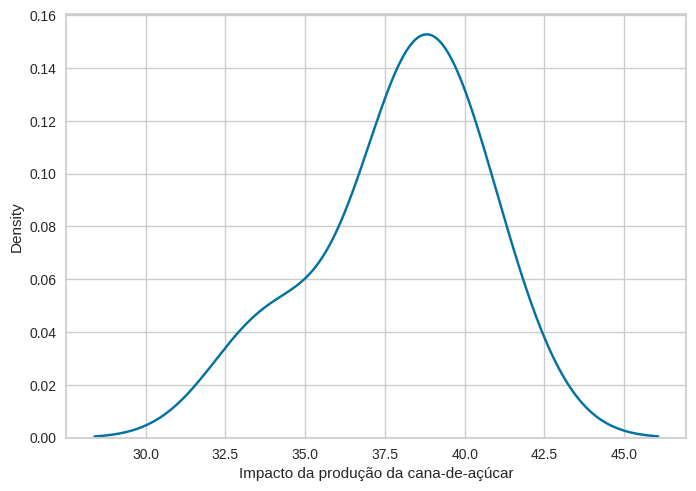

In [60]:
sns.kdeplot(data=df_pt, x='Impacto da produção da cana-de-açúcar')
plt.show()
plt.close()

In [61]:
numerical_features = df_pt.select_dtypes(include=np.number).columns.tolist()
numerical_features.remove('Impacto da produção da cana-de-açúcar')
numerical_features.remove('UF')
numerical_features.remove('Vinhaça')
numerical_features

['Percentual da área queimada',
 'Calcário calcítico',
 'Calcário dolomítico',
 'Gesso',
 'Ureia',
 'Fosfato Monoamônico (MAP)',
 'Fosfato Monoamônico (MAP).1',
 'Fosfato diamônico (DAP)',
 'Fosfato diamônico (DAP).1',
 'Nitrato de amônio',
 'Solução de nitrato de amônio e ureia (UAN)',
 'Amônia anidra',
 'Sulfato de amônio',
 'Nitrato de amônio e cálcio (CAN)',
 'Superfosfato simples (SSP)',
 'Superfosfato triplo (TSP)',
 'Cloreto de potássio (KCl)',
 'Outros',
 'Outros.1',
 'Outros.2',
 'Concentração de N',
 'Torta de Filtro (base úmida)',
 'Concentração de N.1',
 'Cinzas e fuligem (base úmida)',
 'Concentração de N.2',
 'Outros.3',
 'Concentração de N.3',
 'Outros.4',
 'Concentração de N.4',
 'Diesel - B10',
 'Diesel - B11',
 'Diesel - B15',
 'Diesel - BX',
 'Teor de biodiesel na mistura',
 'Diesel - B20',
 'Diesel - B30',
 'Biodiesel - B100',
 'Gasolina C',
 'Etanol hidratado',
 'Biometano de terceiros',
 'Biometano próprio',
 'Eletricidade da rede - mix médio',
 'Eletricidade - PC

In [62]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df_pt[numerical_features] = scaler.fit_transform(df_pt[numerical_features])

numerical_features

['Percentual da área queimada',
 'Calcário calcítico',
 'Calcário dolomítico',
 'Gesso',
 'Ureia',
 'Fosfato Monoamônico (MAP)',
 'Fosfato Monoamônico (MAP).1',
 'Fosfato diamônico (DAP)',
 'Fosfato diamônico (DAP).1',
 'Nitrato de amônio',
 'Solução de nitrato de amônio e ureia (UAN)',
 'Amônia anidra',
 'Sulfato de amônio',
 'Nitrato de amônio e cálcio (CAN)',
 'Superfosfato simples (SSP)',
 'Superfosfato triplo (TSP)',
 'Cloreto de potássio (KCl)',
 'Outros',
 'Outros.1',
 'Outros.2',
 'Concentração de N',
 'Torta de Filtro (base úmida)',
 'Concentração de N.1',
 'Cinzas e fuligem (base úmida)',
 'Concentração de N.2',
 'Outros.3',
 'Concentração de N.3',
 'Outros.4',
 'Concentração de N.4',
 'Diesel - B10',
 'Diesel - B11',
 'Diesel - B15',
 'Diesel - BX',
 'Teor de biodiesel na mistura',
 'Diesel - B20',
 'Diesel - B30',
 'Biodiesel - B100',
 'Gasolina C',
 'Etanol hidratado',
 'Biometano de terceiros',
 'Biometano próprio',
 'Eletricidade da rede - mix médio',
 'Eletricidade - PC

In [63]:
df_scaled = df_pt.copy()
df_scaled['average'] = df_scaled[numerical_features].mean(axis=1)
df_scaled = df_scaled[['UF', 'average', 'Impacto da produção da cana-de-açúcar']]
print(df_scaled)


   UF   average  Impacto da produção da cana-de-açúcar
0   1  0.255154                                  37.85
1   2  0.244536                                  33.86
2   3  0.353580                                  38.46
3   4  0.288965                                  39.01
4   5  0.204301                                  40.61


In [64]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_scaled['UF'] = le.fit_transform(df_scaled['UF'])
df_scaled['UF'] = df_scaled['UF'] + 1

print(df_scaled)

   UF   average  Impacto da produção da cana-de-açúcar
0   1  0.255154                                  37.85
1   2  0.244536                                  33.86
2   3  0.353580                                  38.46
3   4  0.288965                                  39.01
4   5  0.204301                                  40.61


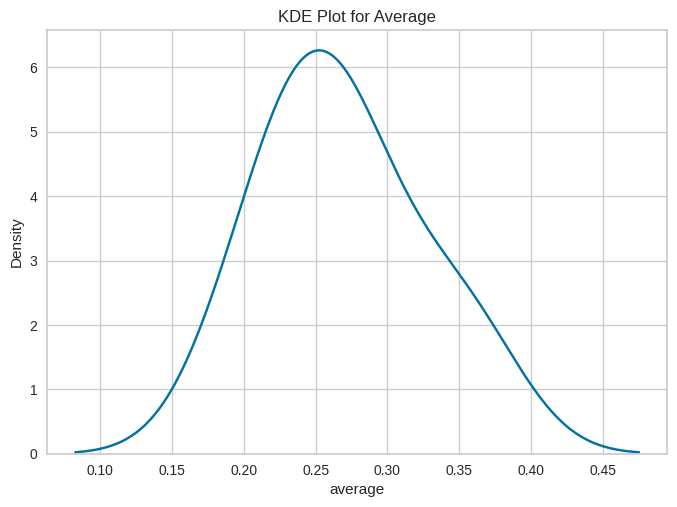

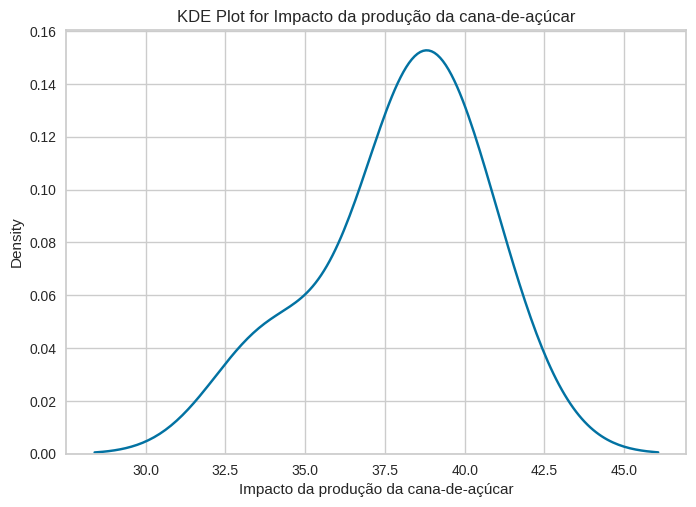

In [65]:
# KDE plot for 'average'
sns.kdeplot(data=df_scaled, x='average')
plt.title('KDE Plot for Average')
plt.show()

# KDE plot for 'Impacto da produção da cana-de-açúcar'
sns.kdeplot(data=df_scaled, x='Impacto da produção da cana-de-açúcar')
plt.title('KDE Plot for Impacto da produção da cana-de-açúcar')
plt.show()


In [66]:
def get_state_name(uf_code):
  if uf_code == 1:
    return 'SP'
  elif uf_code == 2:
    return 'GO'
  elif uf_code == 3:
    return 'MG'
  elif uf_code == 4:
    return 'MS'
  elif uf_code == 5:
    return 'MT'
  else:
    return 'Unknown'

df_scaled['state'] = df_scaled['UF'].apply(get_state_name)
print(df_scaled)


   UF   average  Impacto da produção da cana-de-açúcar state
0   1  0.255154                                  37.85    SP
1   2  0.244536                                  33.86    GO
2   3  0.353580                                  38.46    MG
3   4  0.288965                                  39.01    MS
4   5  0.204301                                  40.61    MT


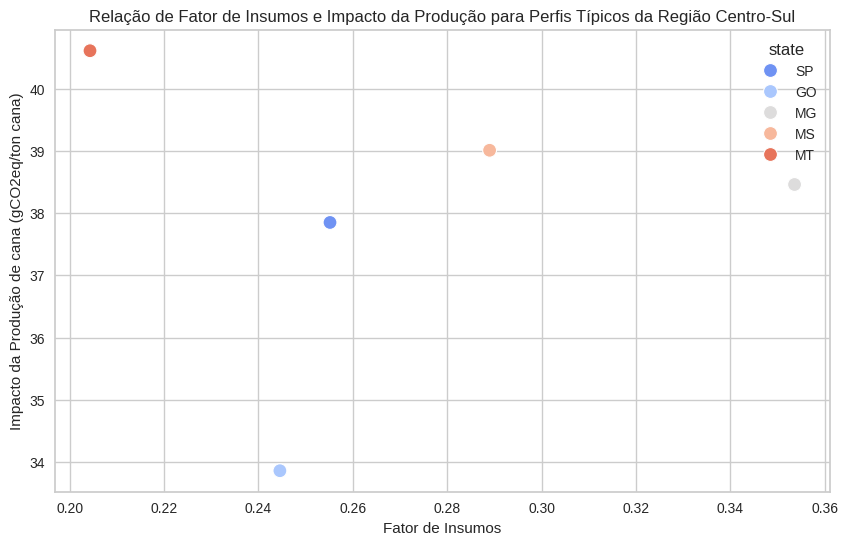

In [67]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_scaled, x='average', y='Impacto da produção da cana-de-açúcar', hue='state', palette='coolwarm', s=100)
plt.title('Relação de Fator de Insumos e Impacto da Produção para Perfis Típicos da Região Centro-Sul')
plt.xlabel('Fator de Insumos')
plt.ylabel('Impacto da Produção de cana (gCO2eq/ton cana)')
plt.show()